# Наивный байесовский классификатор

In [59]:
import math
import re
import random
from collections import defaultdict, Counter
from typing import Set, NamedTuple, List, Tuple, Dict, Iterable, TypeVar

## Теорема Байеса
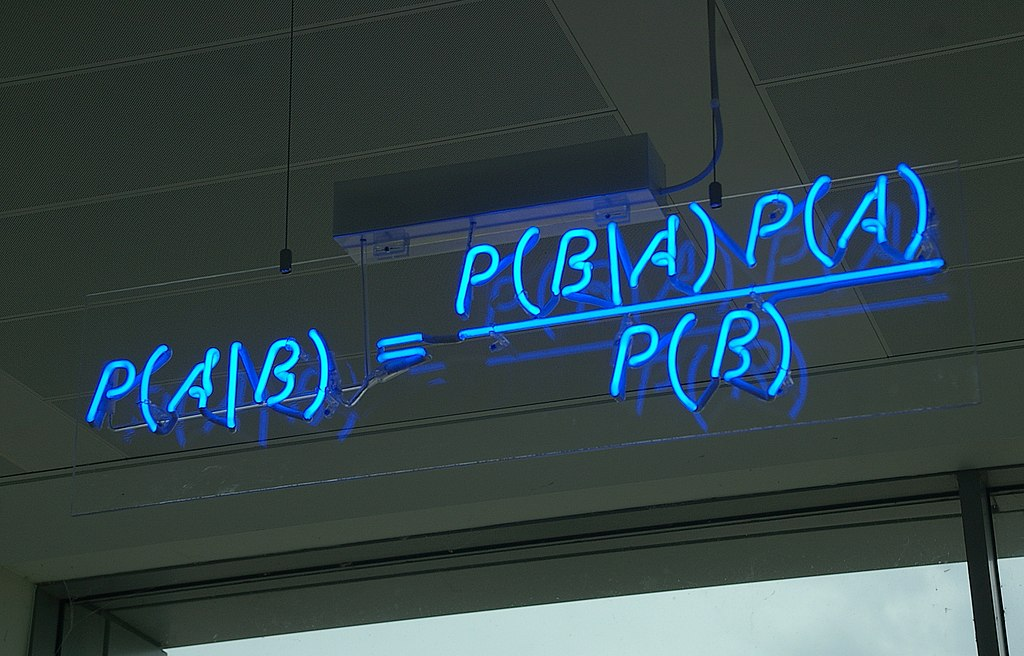

Теорема Байеса (или формула Байеса) — одна из основных теорем элементарной теории вероятностей, которая позволяет определить вероятность какого-либо события при условии, что произошло другое статистически взаимозависимое с ним событие. Другими словами, по формуле Байеса можно более точно пересчитать вероятность, взяв в расчёт как ранее известную информацию, так и данные новых наблюдений. Формула Байеса может быть выведена из основных аксиом теории вероятностей, в частности из условной вероятности. Особенность теоремы Байеса заключается в том, что для её практического применения требуется большое количество расчётов, вычислений, поэтому байесовские оценки стали активно использовать только после революции в компьютерных и сетевых технологиях.

$${\displaystyle P(A\mid B)={\frac {P(B\mid A)\,P(A)}{P(B)}}}$$,
где

- ${\displaystyle P(A)}P(A)$ — априорная вероятность гипотезы A (смысл такой терминологии см. ниже);
- ${\displaystyle P(A\mid B)}{\displaystyle P(A\mid B)}$ — вероятность гипотезы A при наступлении события B (апостериорная вероятность);
- ${\displaystyle P(B\mid A)}{\displaystyle P(B\mid A)}$ — вероятность наступления события B при истинности гипотезы A;
- ${\displaystyle P(B)}P(B)$ — полная вероятность наступления события B.

Прежде всего создадим простую функцию, которая лексемизирует сообщения на отдельные слова без повторов. Сначала мы конвертируем каждое сообщение в нижний регистр, затем применим функцию `re.findall` для извлечения "слов", состоящих из букв, цифр и апострофов, и, наконец, мы применим объект `set` для получения уникальных слов:

In [2]:
def tokenize(text: str) -> Set[str]:
    text = text.lower() # Конвертировать в нижний регистр, 
    all_words = re.findall("[a-z0-9']+", text) # извлечь слова и
    return set(all_words) # удалить повторы.

In [4]:
assert tokenize("Data Science is science") == {"data", "science", "is"}

Мы также определяем тип для наших тренировочных данных:

In [5]:
class Message(NamedTuple):
    text: str
    is_spam: bool

Поскольку наш классификатор должен отслеживать лексемы, количества и метки из тренировочных данных, то мы сделаем его классом. Следуя принятым в английском языке традициям, мы обозначим неспамные сообщения в коде как `ham_messages`.

Конструктор будет принимать только один параметр — псевдосчетчик для использования при вычислении вероятностей. Он также инициализирует пустое множество лексем — счетчики для отслеживания того, как часто каждая лексема встречается в спамных и неспамных сообщениях, — и подсчитывает число спамных и неспамных сообщений, на которых он был натренирован:

```python
class NaiveBayesClassifier:
    def __init__ (self, k: float = 0.5) -> None:
        self.k = k # Сглаживающий фактор
        self.tokens: Set[str] = set()
        self.token_spam_counts: Dict[str, int] = defaultdict(int)
        self.token_ham_counts: Dict[str, int] = defaultdict(int)
        self.spam_messages = self.ham_messages = О
```

Далее мы дадим ему метод, который будет его тренировать на группе сообщений. Сначала мы увеличиваем количества спамных сообщений `spam_messages` и неспамных сообщений `ham_messages`. Затем мы лексемизируем текст каждого сообщения и для каждой лексемы увеличиваем спамные и неспамные количества `token_spam_counts` или `token_ham_counts`, основываясь на типе сообщения:

```python
def train(self, messages: Iterable[Message]) -> None:
    for message in messages:
        # Увеличить количества сообщений
        if message.is_spam:
            self.spam_messages += 1
        else:
            self.ham_messages += 1
        # Увеличить количества появлений слов
        for token in tokenize(message.text):
            self.tokens.add(token)
            if message.is_spam:
                self.token_spam_counts[token] += 1
            else:
                self.token_ham_counts[token] += 1
```

В конечном итоге мы хотим предсказать $Р$(спам | лексема). Как мы видели ранее, для того чтобы применить теорему Байеса, нам нужно знать $Р$(лексема | спам) и $Р$(лексема | неспам) для каждой лексемы в лексиконе. Поэтому для их вычисления мы создадим приватную вспомогательную функцию:

```python
def _probabilities(self, token: str) -> Tuple[float, float]:
    """Возвращает Р(лексема | спам) и Р(лексема | неспам)"""
    spam = self.token_spam_counts[token]
    ham = self.token_ham_counts[token]
    p_token_spam = (spam + self.k) / (self.spam_messages + 2 * self.k)
    p_token_ham = (ham + self.k) / (self.ham_messages + 2 * self.k)
    return p_token_spam, p_token_ham
```

Наконец, мы готовы написать наш метод предсказания `predict`. Как упоминалось ранее, вместо перемножения многочисленных малых вероятностей мы просуммируем логарифмические вероятности:

```python
def predict(self, text: str) -> float:
    text_tokens = tokenize(text)
    log_prob_if_spam = log_prob_if_ham == 0.0
    # Перебрать все слова в лексиконе
    for token in self.tokens:
        prob_if_spam, prob_if_ham = self._probabilities(token)
        # Если лексема появляется в сообщении,
        # то добавить логарифмическую вероятность ее встретить
        if token in text_tokens:
            log_prob_if_spam += math.log(prob_if_spam)
            log_prob_if_ham += math.log(prob_if_ham)
        # В противном случае добавить логарифмическую вероятность 
        # ее НЕ встретить, т. е. log(1 - вероятность ее встретить)
        else:
            log_prob_if_spam += math.log(1.0 - prob_if_spam)
            log_prob_if_ham += math.log(1.0 - prob_if_ham)
     
    prob_if_spam = math.exp(log_prob_if_spam)
    prob_if_ham = math.exp(log_prob_if_ham)
    return prob_if_spam / (prob_if_spam + prob_if_ham)     
```

## Код классификатора

In [32]:
class NaiveBayesClassifier:
    def __init__ (self, k: float = 0.5) -> None:
        self.k = k # Сглаживающий фактор
        self.tokens: Set[str] = set()
        self.token_spam_counts: Dict[str, int] = defaultdict(int)
        self.token_ham_counts: Dict[str, int] = defaultdict(int)
        self.spam_messages = self.ham_messages = 0
    
    def train(self, messages: Iterable[Message]) -> None:
        for message in messages:
            # Увеличить количества сообщений
            if message.is_spam:
                self.spam_messages += 1
            else:
                self.ham_messages += 1
            # Увеличить количества появлений слов
            for token in tokenize(message.text):
                self.tokens.add(token)
                if message.is_spam:
                    self.token_spam_counts[token] += 1
                else:
                    self.token_ham_counts[token] += 1
     
    def _probabilities(self, token: str) -> Tuple[float, float]:
        """Возвращает Р(лексема | спам) и Р(лексема | неспам)"""
        spam = self.token_spam_counts[token]
        ham = self.token_ham_counts[token]
        p_token_spam = (spam + self.k) / (self.spam_messages + 2 * self.k)
        p_token_ham = (ham + self.k) / (self.ham_messages + 2 * self.k)
        return p_token_spam, p_token_ham
    
    def predict(self, text: str) -> float:
        text_tokens = tokenize(text)
        log_prob_if_spam = log_prob_if_ham = 0.0
        # Перебрать все слова в лексиконе
        for token in self.tokens:
            prob_if_spam, prob_if_ham = self._probabilities(token)
            # Если лексема появляется в сообщении,
            # то добавить логарифмическую вероятность ее встретить
            if token in text_tokens:
                log_prob_if_spam += math.log(prob_if_spam)
                log_prob_if_ham += math.log(prob_if_ham)
            # В противном случае добавить логарифмическую вероятность 
            # ее НЕ встретить, т. е. log(1 - вероятность ее встретить)
            else:
                log_prob_if_spam += math.log(1.0 - prob_if_spam)
                log_prob_if_ham += math.log(1.0 - prob_if_ham)

        prob_if_spam = math.exp(log_prob_if_spam)
        prob_if_ham = math.exp(log_prob_if_ham)
        return prob_if_spam / (prob_if_spam + prob_if_ham)   

## Тестирование модели

Давайте убедимся, что наша модель работает, написав для нее несколько модульных тестов.

In [34]:
messages = [Message("spam rules", is_spam=True),
            Message("ham rules", is_spam=False),
            Message("hello ham", is_spam=False)]

model = NaiveBayesClassifier(k=0.5)
model.train(messages)

Сперва проверим, что правильно рассчитаны количества:

In [23]:
assert model.tokens == {"spam", "ham", "rules", "hello"}
assert model.spam_messages == 1
assert model.ham_messages == 2
assert model.token_spam_counts == {"spam": 1, "rules": 1}
assert model.token_ham_counts == {"ham": 2, "rules": 1, "hello": 1}

Теперь сделаем предсказание.

In [38]:
text = "hello spam"

probs_if_spam = [(1 + 0.5) / (1 + 2 * 0.5), # "spam" (присутствует) 
                  1 - (0 + 0.5) / (1 + 2 * 0.5), # "ham"(неприсутствует)
                  1 - (1 + 0.5) / (1 + 2 * 0.5), # "rules" (не присутствует) 
                  (0 + 0.5) / (1 + 2 * 0.5) # "hello" (присутствует)
                 ]

probs_if_ham = [(0 + 0.5) / (2 + 2 * 0.5), # "spam" (присутствует)
                1 - (2 + 0.5) / (2 + 2 * 0.5), #"ham"(неприсутствует)
                1 - (1 + 0.5) / (2 + 2 * 0.5), # "rules" (не присутствует)
                (1 + 0.5) / (2 + 2 * 0.5), # "hello" (присутствует)
               ]

p_if_spam = math.exp(sum(math.log(p) for p in probs_if_spam))
p_if_ham = math.exp(sum(math.log(p) for p in probs_if_ham))

assert model.predict(text) == p_if_spam / (p_if_spam + p_if_ham)
model.predict(text)

0.8350515463917525

Этот тест проходит, поэтому, похоже, наша модель делает то, что мы от нее ожидаем. Если посмотреть на фактические вероятности, то двумя большими движущими силами является то, что наше сообщение содержит спам (что и делало наше одинокое тренировочное спамное сообщение) и что оно не содержит неспама (что и делали оба наших тренировочных сообщения).

Теперь давайте опробуем модель на реальных данных.

## Применение модели

Популярным (хотя и немного устаревшим) набором данных является публичный текстовый корпус под названием SpamAssassin (https://spamassassin.apache.org/publiccorpus/). Мы возьмем файлы с префиксом 20021010.
Вот сценарий, который скачает и распакует их в каталог по вашему выбору (либо вы можете сделать это вручную)

In [40]:
from io import BytesIO # Необходимо трактовать байты как файл
import requests # Для скачивания файлов, которые
import tarfile  # находятся в формате .tar.bz

BASE_URL = "https://spamassassin.apache.org/old/publiccorpus"

FILES = ["20021010_easy_ham.tar.bz2",
         "20021010_hard_ham.tar.bz2",
         "20021010_spam.tar.bz2"]

# В этих папках данные окажутся после распаковки: # /spam, /easy_ham и /hard_ham.
# Можете поменять каталог по своему усмотрению
OUTPUT_DIR = 'spam_data'

In [43]:
for filename in FILES:
    # Используем requests для получения
    # содержимого файлов в каждом URL
    content = requests.get(f"{BASE_URL}/{filename}").content
    # Обернуть байты в памяти, чтобы использовать их как "файл"
    fin = BytesIO(content)
    # И извлечь все файлы в указанный выходной каталог.
    with tarfile.open(fileobj=fin, mode='r:bz2') as tf:
        tf.extractall(OUTPUT_DIR)

После скачивания данных у вас должно быть три папки: spam, easy_ham и hard_ham. Каждая папка содержит много писем, каждое из которых находится в одном файле. Для того чтобы все было действительно просто, мы будем просматривать тематические строки каждого письма.

Как вычленить строку с темой? Когда мы просматриваем файлы, то видим, что все они, похоже, начинаются со слова "Subject:". Поэтому мы будем искать именно эту цепочку символов:

In [44]:
import glob
# Замените этот путь на любой каталог, в который вы поместили файлы
path = 'spam_data/*/*'
data: List[Message] = []
# glob.glob возвращает каждое имя файла,
# которое соответствует поисковому шаблону пути
for filename in glob.glob(path):
    is_spam = "ham" not in filename
    # В письмах имеются несколько мусорных символов;
    # параметр errors='ignore' пропускает их вместо
    # вызова исключения
    with open(filename, errors='ignore') as email_file:
        for line in email_file:
            if line.startswith("Subject:"):
                subject = line.lstrip("SuЬject: ")
                data.append(Message(subject, is_spam))
                break # С этим файлом работа закончена

Теперь мы можем разбить данные на тренировочные и тестовые, после чего всё готово для построения классификатора:

In [56]:
X = TypeVar('Х') # Обобщенный тип для представления точки данных

def split_data(data: List[X], prob: float) -> Tuple[List[X], List[X]]:
    """Разбить данные на доли [prob, 1 - prob]"""
    data = data[:] # Сделать мелкую копию,
    random.shuffle(data) # т. к. shuffle модифицирует список.
    cut = int(len(data) * prob) # Применить prob для отыскания отсечения
    return data[:cut], data[cut:] # и разбить там перетасованный список

In [57]:
random.seed(0) # Требуется для получения тех же ответов
train_messages, test_messages = split_data(data, 0.75)

In [58]:
model = NaiveBayesClassifier()
model.train(train_messages)

Давайте сгенерируем несколько предсказаний и проверим, как наша модель работает:

In [60]:
predictions = [(message, model.predict(message.text)) for message in test_messages]

# Будем считать, что спамная вероятность sparn_probability > 0.5
# соответствует предсказанию спама, и подсчитаем комбинации
# (фактический спам is_sparn, предсказанный спам is_spam)
confusion_matrix = Counter((message.is_spam, spam_probability > 0.5) for message, spam_probability in predictions)
print(confusion_matrix)

Counter({(False, False): 667, (True, True): 85, (True, False): 54, (False, True): 19})


Это даст 85 истинных утверждений (спам классифицируется как "спам"), 19 ложных утверждений (неспам классифицируется как "спам"), 667 истинных отрицаний (неспам классифицируется как "неспам") и 54 ложных отрицания (спам классифицируется как "неспам"). Это означает, что прецизионность равна 85 / (85 + 19) = 82%, а полнота равна 85 / (85 + 54) = 61%, что совсем неплохо для такой простой модели. (По-видимому, было бы еще лучше, если бы мы просматривали не только темы.)

Мы также можем обследовать внутренности модели, чтобы увидеть, какие слова больше всего и меньше всего указывают на спам:

In [103]:
def p_spam_given_token(token: str, model: NaiveBayesClassifier) -> float:
    prob_if_spam, prob_if_ham = model._probabilities(token)
    return prob_if_spam / (prob_if_spam + prob_if_ham)

words = sorted(model.tokens, key=lambda t: p_spam_given_token(t, model))

print("наиболее спамные слова: ", *words[-10:])
print("наименее спамные слова: ", *words[:10])

наиболее спамные слова:  99 95 account sale attn zzzz money systemworks rates adv
наименее спамные слова:  spambayes 2 users razor zzzzteana sadev ouch apt selling bliss


Наиболее спамные слова включают такие вещи, как sale (распродажа), mortgage (закладная), money (деньги) и rates (ставки, цены), тогда как наименее спамные слова включают такие вещи, как spambayes (байесов спам-фильтр), users (пользователи), apt (квартира) и perl (жемчуг). Это также дает нам некоторую интуитивную уверенность в том, что наша модель в основном поступает правильно.

Каким образом можно получить более высокую результативность? Один из очевидных способов — предоставить больше тренировочных данных. Кроме этого, есть ряд других способов улучшения модели. Вот несколько возможностей, которые стоит попробовать.

 - Просматривать не только темы, но и содержимое сообщений. Следует внимательно отнестись к обработке заголовков сообщений.
 - Нашклассификаторучитываетвсеслова,которыепоявляютсявтренировочном наборе, даже те, которые появляются всего один раз. Следует модифицировать классификатор так, чтобы он принимал необязательный порог `min_count` и игнорировал слова, число появлений которых меньше порога.
 - Лексемизатор не имеет понятия о похожих словах (к примеру, cheap и cheapest — дешевый, дешевейший). Можно модифицировать классификатор так, чтобы он включал необязательую функцию-стеммер для выделения основ слов, которая конвертирует слова в *классы эквивалентности*. Создание хорошей функции выделения основ слов — задача сложная. Для отыскания основы слова часто пользуются алгоритмом <a href="https://ru.wikipedia.org/wiki/Cтeммep_Пopтepa">Портера</a>
 - Хотя все наши признаки имеют форму "сообщение содержит слово $w_{i}$", нет никаких причин, почему это должно быть именно так. В нашей имплементации мы могли бы добавить дополнительные признаки, такие как "сообщение содержит число", путем создания фиктивных слов, таких как *содержит:число*, и модифицирования лексемизатора `tokenizer` так, чтобы он эмитировал их в случае необходимости.